# CHAPTER 14 数据分析实例

# 14.1 USA.gov Data from Bitly



In [1]:
import json
path = '../datasets/bitly_usagov/example.txt'
records = [json.loads(line) for line in open(path)]

In [2]:
records[0]

{'a': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11',
 'al': 'en-US,en;q=0.8',
 'c': 'US',
 'cy': 'Danvers',
 'g': 'A6qOVH',
 'gr': 'MA',
 'h': 'wfLQtf',
 'hc': 1331822918,
 'hh': '1.usa.gov',
 'l': 'orofrog',
 'll': [42.576698, -70.954903],
 'nk': 1,
 'r': 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf',
 't': 1331923247,
 'tz': 'America/New_York',
 'u': 'http://www.ncbi.nlm.nih.gov/pubmed/22415991'}

In [3]:
records[0]['tz']

'America/New_York'

# 1 Counting Time Zones in Pure Python（用纯python代码对时区进行计数）

我们想知道数据集中出现在哪个时区（即tz字段）

In [4]:
time_zones = [rec['tz'] for rec in records]

KeyError: 'tz'

并不是所有的记录都有时区字段。那么只需要在推导式的末尾加一个if 'tz' in rec判断即可

In [5]:
time_zones = [rec['tz'] for rec in records if 'tz' in rec]

In [6]:
time_zones[:10]

['America/New_York',
 'America/Denver',
 'America/New_York',
 'America/Sao_Paulo',
 'America/New_York',
 'America/New_York',
 'Europe/Warsaw',
 '',
 '',
 '']

在这10条时区信息中，可以看到有些是空字符串，现在先留着。

为了对时区进行计数，我们用两种方法：一个用纯python代码，比较麻烦。另一个用pandas，比较简单。 这里我们先介绍使用纯python代码的方法：

遍历时区的过程中将计数值保存在字典中：

In [7]:
def get_counts(sequence):
    counts = {}
    for x in sequence:
        if x in counts:
            counts[x] += 1
        else:
            counts[x] = 1
    return counts

使用python标准库的话，能把代码写得更简洁一些：

In [9]:
from collections import defaultdict

def get_counts2(sequence):
    counts = defaultdict(int) # 所有的值均会被初始化为0
    for x in sequence:
        counts[x] += 1
    return counts

In [10]:
someddict = defaultdict(int)
print(someddict[3])

0


In [11]:
someddict[3]

0

上面用函数的方式写出来是为了有更高的可用性。要对它进行时区处理，只需要将time_zones传入即可：

In [12]:
counts = get_counts(time_zones)

In [13]:
counts['America/New_York']

1251

In [14]:
len(time_zones)

3440

如何想要得到前10位的时区及其计数值，我们需要一些有关字典的处理技巧：

In [15]:
def top_counts(count_dict, n=10):
    value_key_pairs = [(count, tz) for tz, count in count_dict.items()]
    value_key_pairs.sort()
    return value_key_pairs[-n:]

In [16]:
top_counts(counts)

[(33, 'America/Sao_Paulo'),
 (35, 'Europe/Madrid'),
 (36, 'Pacific/Honolulu'),
 (37, 'Asia/Tokyo'),
 (74, 'Europe/London'),
 (191, 'America/Denver'),
 (382, 'America/Los_Angeles'),
 (400, 'America/Chicago'),
 (521, ''),
 (1251, 'America/New_York')]

如果用python标准库里的collections.Counter类，能让这个任务变得更简单

In [17]:
from collections import Counter

In [18]:
counts = Counter(time_zones)

In [19]:
counts.most_common(10)

[('America/New_York', 1251),
 ('', 521),
 ('America/Chicago', 400),
 ('America/Los_Angeles', 382),
 ('America/Denver', 191),
 ('Europe/London', 74),
 ('Asia/Tokyo', 37),
 ('Pacific/Honolulu', 36),
 ('Europe/Madrid', 35),
 ('America/Sao_Paulo', 33)]

# 2 Counting Time Zones with pandas（用pandas对时区进行计数）

从一组原始记录中创建DataFrame是很简单的，直接把records传递给pandas.DataFrame即可：


In [20]:
import pandas as pd
import numpy as np

In [21]:
frame = pd.DataFrame(records)

In [22]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560 entries, 0 to 3559
Data columns (total 18 columns):
_heartbeat_    120 non-null float64
a              3440 non-null object
al             3094 non-null object
c              2919 non-null object
cy             2919 non-null object
g              3440 non-null object
gr             2919 non-null object
h              3440 non-null object
hc             3440 non-null float64
hh             3440 non-null object
kw             93 non-null object
l              3440 non-null object
ll             2919 non-null object
nk             3440 non-null float64
r              3440 non-null object
t              3440 non-null float64
tz             3440 non-null object
u              3440 non-null object
dtypes: float64(4), object(14)
memory usage: 500.7+ KB


In [23]:
frame['tz'][:10]

0     America/New_York
1       America/Denver
2     America/New_York
3    America/Sao_Paulo
4     America/New_York
5     America/New_York
6        Europe/Warsaw
7                     
8                     
9                     
Name: tz, dtype: object

In [24]:
tz_counts = frame['tz'].value_counts()

In [25]:
tz_counts[:10]

America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: tz, dtype: int64

我们能利用matplotlib为这段数据生成一张图片。这里我们先给记录中未知或缺失的时区填上一个替代值。fillna函数可以替代缺失值（NA），而未知值（空字符串）则可以通过布尔型数组索引，加以替换：

In [26]:
clean_tz = frame['tz'].fillna('Missing')

In [27]:
clean_tz[clean_tz == ''] = 'Unknown'

In [28]:
tz_counts = clean_tz.value_counts()

In [29]:
tz_counts[:10]

America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: tz, dtype: int64

利用counts对象的plot方法即可得到一张水平条形图：

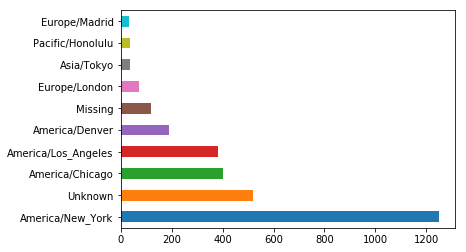

In [30]:
%matplotlib inline
tz_counts[:10].plot(kind='barh', rot=0)

当然，我们也可以使用之前介绍的seaborn来画一个水平条形图（horizontal bar plot）：

In [31]:
import seaborn as sns

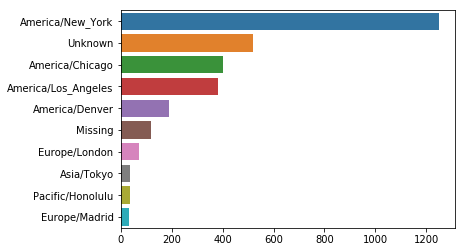

In [32]:
subset = tz_counts[:10]
sns.barplot(y=subset.index, x=subset.values)

我们还可以对这种数据进行更多的处理。比如a字段含有执行URL操作的浏览器、设备、应用程序的相关信息：

In [33]:
frame['a'][1]

'GoogleMaps/RochesterNY'

In [34]:
frame['a'][50]

'Mozilla/5.0 (Windows NT 5.1; rv:10.0.2) Gecko/20100101 Firefox/10.0.2'

In [35]:
frame['a'][51]

'Mozilla/5.0 (Linux; U; Android 2.2.2; en-us; LG-P925/V10e Build/FRG83G) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1'

In [36]:
frame['a'][:5]

0    Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1                               GoogleMaps/RochesterNY
2    Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...
3    Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...
4    Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
Name: a, dtype: object

将这些USER_AGENT字符串中的所有信息都解析出来是一件挺郁闷的工作。不过只要掌握了Python内置的字符串函数和正则表达式，就方便了。比如，我们可以把字符串的第一节（与浏览器大致对应）分离出来得到另一份用户行为摘要：

In [46]:
cframe = frame[frame.a.notnull()]
cframe.head()

,_heartbeat_,a,al,c,cy,g,gr,h,hc,hh,kw,l,ll,nk,r,t,tz,u
0,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Danvers,A6qOVH,MA,wfLQtf,1.331823e+09,1.usa.gov,NaN,orofrog,"[42.576698, -70.954903]",1.0,http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/...,1.331923e+09,America/New_York,http://www.ncbi.nlm.nih.gov/pubmed/22415991
1,NaN,GoogleMaps/RochesterNY,NaN,US,Provo,mwszkS,UT,mwszkS,1.308262e+09,j.mp,NaN,bitly,"[40.218102, -111.613297]",0.0,http://www.AwareMap.com/,1.331923e+09,America/Denver,http://www.monroecounty.gov/etc/911/rss.php
2,NaN,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,en-US,US,Washington,xxr3Qb,DC,xxr3Qb,1.331920e+09,1.usa.gov,NaN,bitly,"[38.9007, -77.043098]",1.0,http://t.co/03elZC4Q,1.331923e+09,America/New_York,http://boxer.senate.gov/en/press/releases/0316...
3,NaN,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,pt-br,BR,Braz,zCaLwp,27,zUtuOu,1.331923e+09,1.usa.gov,NaN,alelex88,"[-23.549999, -46.616699]",0.0,direct,1.331923e+09,America/Sao_Paulo,http://apod.nasa.gov/apod/ap120312.html
4,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"en-US,en;q=0.8",US,Shrewsbury,9b6kNl,MA,9b6kNl,1.273672e+09,bit.ly,NaN,bitly,"[42.286499, -71.714699]",0.0,http://www.shrewsbury-ma.gov/selco/,1.331923e+09,America/New_York,http://www.shrewsbury-ma.gov/egov/gallery/1341...


其次根据a值计算出各行是否是windows：

In [47]:
cframe['os'] = np.where(cframe['a'].str.contains('Windows'), 
                            'Windows', 'Not Windows')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [48]:
cframe['os'][:5]

0        Windows
1    Not Windows
2        Windows
3    Not Windows
4        Windows
Name: os, dtype: object

接下来就可以根据时区和新得到的操作系统列表对数据进行分组了：

In [49]:
by_tz_os = cframe.groupby(['tz', 'os'])

In [50]:
by_tz_os.size()

tz                              os         
                                Not Windows    245
                                Windows        276
Africa/Cairo                    Windows          3
Africa/Casablanca               Windows          1
Africa/Ceuta                    Windows          2
Africa/Johannesburg             Windows          1
Africa/Lusaka                   Windows          1
America/Anchorage               Not Windows      4
                                Windows          1
America/Argentina/Buenos_Aires  Not Windows      1
America/Argentina/Cordoba       Windows          1
America/Argentina/Mendoza       Windows          1
America/Bogota                  Not Windows      1
                                Windows          2
America/Caracas                 Windows          1
America/Chicago                 Not Windows    115
                                Windows        285
America/Chihuahua               Not Windows      1
                                Window

上面通过size对分组结果进行计数，类似于value_counts函数，并利用unstack对计数结果进行重塑为一个表格：

In [51]:
agg_counts = by_tz_os.size().unstack().fillna(0)

In [52]:
agg_counts[:10]

os,Not Windows,Windows
tz,,
,245.0,276.0
Africa/Cairo,0.0,3.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,0.0,1.0
Africa/Lusaka,0.0,1.0
America/Anchorage,4.0,1.0
America/Argentina/Buenos_Aires,1.0,0.0
America/Argentina/Cordoba,0.0,1.0


最后，我们来选取最常出现的时区。为了达到这个目的，根据agg_counts中的行数构造了一个简洁索引数组：

In [53]:
indexer = agg_counts.sum(1).argsort()
indexer[:10]

tz
                                  24
Africa/Cairo                      20
Africa/Casablanca                 21
Africa/Ceuta                      92
Africa/Johannesburg               87
Africa/Lusaka                     53
America/Anchorage                 54
America/Argentina/Buenos_Aires    57
America/Argentina/Cordoba         26
America/Argentina/Mendoza         55
dtype: int64

In [54]:
indexer = agg_counts.sum(1).argsort()
indexer[:10]

tz
                                  24
Africa/Cairo                      20
Africa/Casablanca                 21
Africa/Ceuta                      92
Africa/Johannesburg               87
Africa/Lusaka                     53
America/Anchorage                 54
America/Argentina/Buenos_Aires    57
America/Argentina/Cordoba         26
America/Argentina/Mendoza         55
dtype: int64

然后通过take按照这个顺序截取了最后10行：

In [55]:
count_subset = agg_counts.take(indexer)[-10:]
count_subset

os,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


pandas有一个很方便的方法叫nlargest，可以实现相同效果：

In [56]:
agg_counts.sum(1).nlargest(10)

tz
America/New_York       1251.0
                        521.0
America/Chicago         400.0
America/Los_Angeles     382.0
America/Denver          191.0
Europe/London            74.0
Asia/Tokyo               37.0
Pacific/Honolulu         36.0
Europe/Madrid            35.0
America/Sao_Paulo        33.0
dtype: float64

上面的输出结果可以画成条形图；通过给seaborn的barplot函数传递一个参数，来画出堆积条形图（stacked bar plot）：

In [57]:
# Rearrange the data for plotting
count_subset = count_subset.stack()
count_subset.head()

tz                 os         
America/Sao_Paulo  Not Windows    13.0
                   Windows        20.0
Europe/Madrid      Not Windows    16.0
                   Windows        19.0
Pacific/Honolulu   Not Windows     0.0
dtype: float64

In [58]:
count_subset.name = 'total'
count_subset = count_subset.reset_index()
count_subset[:10]

,tz,os,total
0,America/Sao_Paulo,Not Windows,13.0
1,America/Sao_Paulo,Windows,20.0
2,Europe/Madrid,Not Windows,16.0
3,Europe/Madrid,Windows,19.0
4,Pacific/Honolulu,Not Windows,0.0
5,Pacific/Honolulu,Windows,36.0
6,Asia/Tokyo,Not Windows,2.0
7,Asia/Tokyo,Windows,35.0
8,Europe/London,Not Windows,43.0
9,Europe/London,Windows,31.0


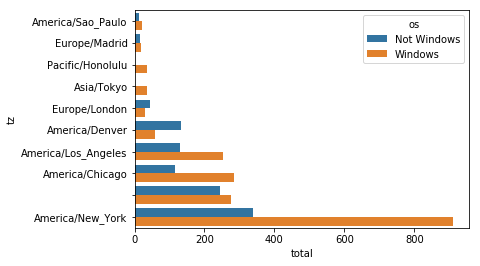

In [59]:
sns.barplot(x='total', y='tz', hue='os', data=count_subset)

由于这张图中不太容易看清楚较小分组中windows用户的相对比例，因此我们可以将各行规范化为“总计为1”并重新绘图：

In [60]:
def norm_total(group):
    group['normed_total'] = group.total / group.total.sum()
    return group

results = count_subset.groupby('tz').apply(norm_total)

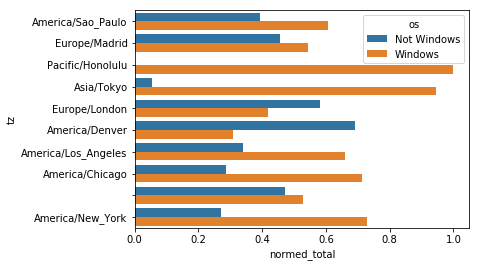

In [61]:
sns.barplot(x='normed_total', y='tz', hue='os', data=results)

我们还可以使用transform和groupby，来更有效率地计算规范化的和：

In [62]:
g = count_subset.groupby('tz')
results2 = count_subset.total / g.total.transform('sum')

译者：下面的内容是不适用seaborn的画图方法，这种画法是2013年第一版中的内容：

In [63]:
count_subset = agg_counts.take(indexer)[-10:]
count_subset

os,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


这里也可以生成一张条形图。我们使用stacked=True来生成一张堆积条形图：

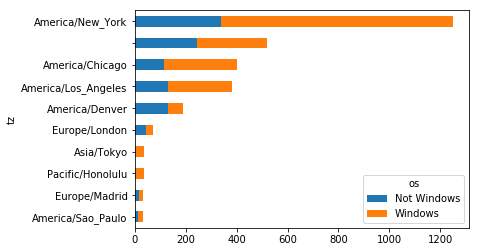

In [64]:
count_subset.plot(kind='barh', stacked=True)

由于这张图中不太容易看清楚较小分组中windows用户的相对比例，因此我们可以将各行规范化为“总计为1”并重新绘图：

In [65]:
normed_subset = count_subset.div(count_subset.sum(1), axis=0)

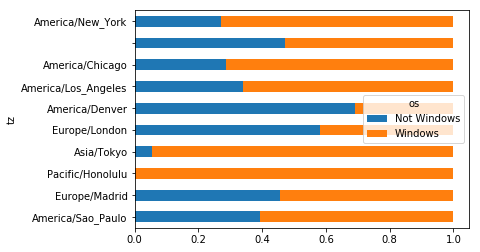

In [66]:
normed_subset.plot(kind='barh', stacked=True)